#### Carregamento dos dados

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

# Carregar o dataset Boston Housing
data = fetch_openml(name="Boston", version=1, as_frame=True)
df = data.frame

# Variável resposta e preditores
X = df.drop(columns=["MEDV"]) # Todas as colunas, exceto a variável alvo
y = df["MEDV"] # Variável alvo (preço das casas)

#### Best Subset Selection

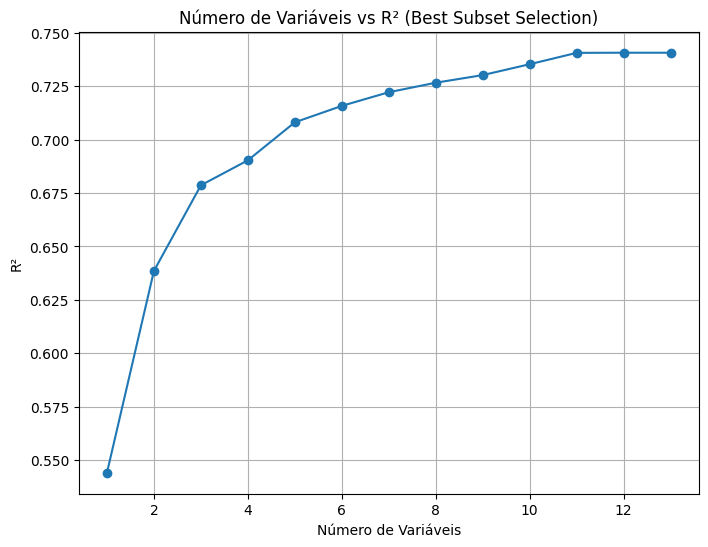

Tempo total de execução: 26.91 segundos


In [2]:
import itertools
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def best_subset_selection(X, y):
  n_features = X.shape[1]
  subsets = []
  r2_values = []
  times = []
  start_time = time.time()

  # Testar todos os possíveis subconjuntos
  for k in range(1, n_features + 1):
    best_r2 = -np.inf
    best_subset = None
    for subset in itertools.combinations(range(n_features), k):
      X_subset = np.array(X.iloc[:, list(subset)])
      model = LinearRegression().fit(X_subset, y)
      r2 = r2_score(y, model.predict(X_subset))

      if r2 > best_r2:
        best_r2 = r2
        best_subset = subset

    subsets.append(best_subset)
    r2_values.append(best_r2)
    times.append(time.time() - start_time)

  return subsets, r2_values, times

# Aplicar Best Subset Selection
subsets, r2_values, times = best_subset_selection(X, y)

# Gráfico de R² vs Número de Variáveis
plt.figure(figsize=(8, 6))
plt.plot(range(1, X.shape[1] + 1), r2_values, marker="o")
plt.xlabel("Número de Variáveis")
plt.ylabel("R²")
plt.title("Número de Variáveis vs R² (Best Subset Selection)")
plt.grid(True)
plt.show()
print(f"Tempo total de execução: {times[-1]:.2f} segundos")

#### Validação Cruzada para Subconjuntos Selecionado

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

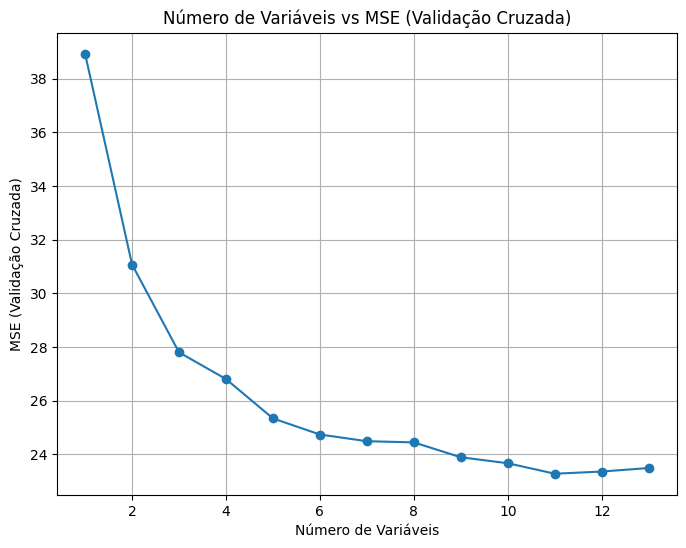

In [6]:
def cross_validate_best_subset(X, y, subsets, k_folds=5):
  mse_values = []
  kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
  for subset in subsets:
    mse_fold = []

    for train_index, test_index in kf.split(X):
      X_train = np.array(X.iloc[train_index, list(subset)])
      X_test = np.array(X.iloc[test_index, list(subset)])
      y_train = np.array(y.iloc[train_index])
      y_test = np.array(y.iloc[test_index])
      model = LinearRegression().fit(X_train, y_train)
      y_pred = model.predict(X_test)
      mse_fold.append(mean_squared_error(y_test, y_pred))

    mse_values.append(np.mean(mse_fold))

  return mse_values

mse_values = cross_validate_best_subset(X, y, subsets)
plt.figure(figsize=(8, 6))
plt.plot(range(1, X.shape[1] + 1), mse_values, marker="o")
plt.xlabel("Número de Variáveis")
plt.ylabel("MSE (Validação Cruzada)")
plt.title("Número de Variáveis vs MSE (Validação Cruzada)")
plt.grid(True)
plt.show()

Análise
1. Levando em conta a simplicidade e eficiência, você escolheria um subconjunto com quantas variáveis? Por que?  

De 6 a 8 variáveis. A partir de 6 variáveis, vemos que o MSE ainda diminui um pouco seu valor, porém tende a se estabilizar, então não é um bom trade-off escolher muito mais que 8 variáveis já que grande parte da redução do MSE já foi realizada.
Além disso, vemos que o $ R^2 $, a partir de 6 variáveis, começa a crescer lentamente e muito pouco, o que indica que já atingimos uma estabilidade e que nosso modelo já está se ajustando adequadamente a nossas amostras.

2. Observe o tempo de execução do algoritmo. Em que casos você usaria ele?  

O custo computacional do Best Subset Selection é elevado, já que envolve analisar todos os possíveis subconjuntos de variáveis preditoras para encontrar aquele que maximiza o $ R^2 $, nesse caso.  
Portanto, o ideal é utiliza-lo para conjunto de dados pequenos.

### Parte 2: Regularização em Modelos de Regressão

#### Regularização dos dados

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = data.frame
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Função para plotar os gráficos
def plot_real_vs_pred(y_test, y_pred, title):
  plt.figure(figsize=(6,6))
  plt.scatter(y_test, y_pred, alpha=0.5, label='Valores Preditos')
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Linha Ideal')
  plt.xlabel('Valores Reais')
  plt.ylabel('Valores Preditos')
  plt.legend()
  plt.title(title)
  plt.show()


#### Ridge Regression

Ridge Regression é uma técnica de regressão linear regularizada que adiciona um termo de penalidade à função de custo da Regressão Linear tradicional. O objetivo da Ridge Regression é evitar o overfitting e melhorar a generalização do modelo em situações onde há multicolinearidade ou um grande número de variáveis.

A penalidade adicionada é L2:  
$ {\alpha}∑_{j=1}^{N}{w_j}² $

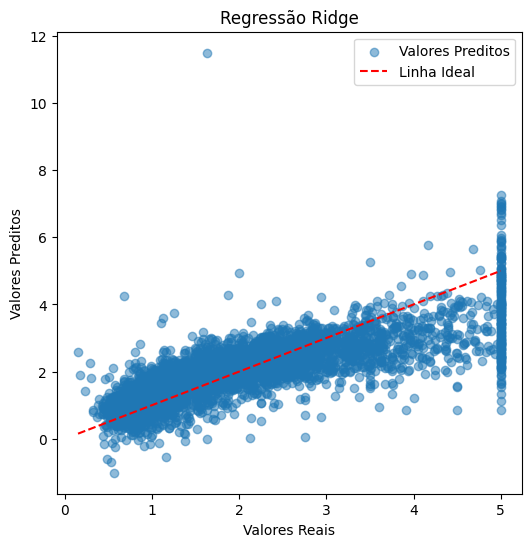

MSE Ridge: 0.5559


In [19]:
alpha_r = 0.2

# Treinando o modelo Ridge
ridge_model = Ridge(alpha_r)
ridge_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_ridge = ridge_model.predict(X_test)

# Plot para Ridge
plot_real_vs_pred(y_test, y_pred_ridge, 'Regressão Ridge')

# Cálculo do MSE
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"MSE Ridge: {mse_ridge:.4f}")

#### Lasso Regression
Segue o mesmo princípio que a Ridge Regression, porém a penalização é L1.

A penalidade adicionada é L1:  
$ {\alpha}∑_{j=1}^{N}|{w_j}| $

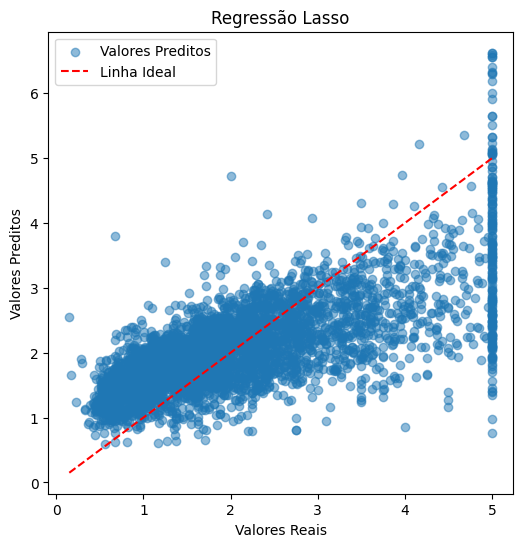

MSE Lasso: 0.6657


In [18]:
alpha_l = 0.2

# Treinando o modelo Lasso
lasso_model = Lasso(alpha_l)
lasso_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_lasso = lasso_model.predict(X_test)

# Plot para Lasso
plot_real_vs_pred(y_test, y_pred_lasso, 'Regressão Lasso')

# Cálculo do MSE
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"MSE Lasso: {mse_lasso:.4f}")

#### Discussão

1. Qual dos dois modelos se saiu melhor no dataset California Housing?

A Ridge Regression. Seu MSE foi menor, o que indica que a reta de regressão está levemente melhor ajustada aos dados.

2. Altere os valores de alpha nos dois modelos para 1 e depois para 10. O que
acontece?

A Regressão Lasso teve uma piora significativa em sua performance, aumetando drasticamente o MSE, enquanto a Ridge permaneceu, majoritariamente, da mesma forma.

Isso é devido ao fato de que, com o aumento de alpha, a Lasso pode reduzir alguns coeficientes a 0, devido a penalização ser L1, o que pode produzir efeito indesejado de underfitting, em que a reta de regressão não explica a variável preditora.

Enquanto isso, a Ridge reduz a magnitude dos coeficientes, mas nunca os reduz exatamente a 0, portanto a penalização é diferente da realizada pela Lasso.

3. Após analisar o desempenho dos dois métodos com o aumento da colinearidade, a
que conclusão você chega?

Os dois métodos, diferente da Regressão Linear, lidam bem com a colinearidade, adicionando regularização (a penalidade, em cada método) que reduz a magnitude dos coeficientes e, dessa forma, controla o impacto da colinearidade entre variáveis preditorias.

Porém, a forma que cada método lida com a colinearidade é diferente:  
Ridge: Com o aumento da colinearidade, o desempenho do modelo de Ridge Regression tende a ser mais estável (já que reduz a magnitude dos coeficientes, mas não zera), com uma melhora na capacidade de generalização (menor erro de validação) em comparação com a Regressão Linear simples.  

Lasso: À medida que a colinearidade aumenta, Lasso tende a eliminar algumas variáveis redundantes, o que pode melhorar a interpretabilidade do modelo, mas, em alguns casos, pode prejudicar a capacidade preditiva se as variáveis eliminadas contêm informações úteis, que provavelmente foi o que aconteceu em nosso caso, quando aumentamos o valor de alpha.